# 2D bounding box model

In this notebook, we implement a deep neural network that takes as input monocular (left camera) KITTI images and outputs 2D bounding boxes. Our model will be a pretrained YOLO network.

In [69]:
# Import statements.
import os
import imageio
from tqdm import tqdm
from PIL import Image
import numpy as np
from typing import Tuple, Optional, Dict, Any
from matplotlib.pyplot import imshow
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, \
    preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, \
    preprocess_true_boxes, yolo_loss, yolo_body

In [2]:
print('Recommended TensorFlow version: 1.15.0')
print('Currently running: {0}'.format(tf.__version__))
if not tf.__version__.startswith('1.'):
    raise ValueError('This module is only compatible with TensorFlow 1.0.')

Recommended TensorFlow version: 1.15.0
Currently running: 1.15.0


In [66]:
# Global constants.
YOLO_MODEL_INPUT_SHAPE = (608, 608, 3)
CLASS_NAMES = read_classes(os.path.join('yolo_config', 'coco_classes.txt'))
ANCHORS = read_anchors(os.path.join('yolo_config', 'yolo_anchors.txt'))
YOLO_MODEL_PATH = os.path.join('yolo_config', 'yolo.h5')
KITTI_CLASSES = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting',
                 'Cyclist', 'Tram', 'Misc', 'DontCare']
COCO_TO_KITTI_CLASS = {
    'car': 'Car',
    'truck': 'Truck',
    'person': 'Pedestrian'}
INVALID_TRUNCATION = -1
INVALID_OCCLUSION = -1
INVALID_ALPHA = -10
INVALID_3D_HWL = -1
INVALID_3D_LOC = -1000
INVALID_RY = -10
TRAIN_LABEL_DIR = os.path.join('..', 'data', 'KITTI', 'training', 'label_2')
TRAIN_IMAGE_DIR = os.path.join('..', 'data', 'KITTI', 'data_object_image_2',
                               'training', 'image_2')
TEST_IMAGE_DIR = os.path.join('..', 'data', 'KITTI', 'data_object_image_2',
                              'testing', 'image_2')
TRAIN_PREDICT_DIR = os.path.join('..', 'data', 'predictions', '2d_boxes',
                                 'train')
TEST_PREDICT_DIR = os.path.join('..', 'data', 'predictions', '2d_boxes',
                                'test')

In [4]:
def yolo_filter_boxes(
    box_confidence: np.ndarray,
    boxes: np.ndarray,
    box_class_probs: np.ndarray,
    threshold: float = 0.6) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Filters YOLO boxes by thresholding on object and class confidence.
    :param box_confidence: The confidences associated with each anchor box; a
    tensor of shape (19, 19, 5, 1), where each entry is the probability that an
    object was detected in each of the 5 anchor boxes for that cell.
    :param boxes: The midpoint and dimensions (x, y, height, width) of each
    bounding box; a tensor of shape (19, 19, 5, 4).
    :param box_class_probs: The probability that the detected object (if any)
    belongs to each class; a tensor of shape (19, 19, 5, 80).
    :param threshold: If the highest class score (box confidence * class
    probability) is lower than the threshold, remove the corresponding box.
    :return: A 3 tuple of scores, boxes, and classes for the best boxes. Scores
    contains the class probability scores for selected boxes; a tensor of shape
    (None,). Boxes contains the coordinates (midpoint, height, and width) of
    selected boxes; a tensor of shape (None, 4). Classes contains the index of
    the class detected by the selected boxes; a tensor of shape (None,). None is
    the number of selected boxes, which varies based on the input image.
    """
    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    # TODO use the argmax results as indices, rather than recomputing the max.
    box_class_scores = K.max(box_scores, axis=-1)
    filtering_mask = box_class_scores >= threshold
    scores  = box_class_scores[filtering_mask]
    boxes   = boxes[filtering_mask]
    classes = box_classes[filtering_mask]
    return scores, boxes, classes

In [5]:
def iou(box1: Tuple[float, float, float, float],
        box2: Tuple[float, float, float, float]) -> float:
    """Returns the intersection over union (IoU) between box1 and box2.
    :param box1: The first box, (x1, y1, x2, y2) where (x1, y1) is the upper
    left corner and (x2, y2) is the lower right corner. These are normalized on
    the size of the image, so that x and y are in the interval [0, 1].
    :param box2: The second box, (x1, y1, x2, y2) where (x1, y1) is the upper
    left corner and (x2, y2) is the lower right corner. These are normalized on
    the size of the image, so that x and y are in the interval [0, 1].
    :return: The intersection over union metric.
    """
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_width  = max(xi2-xi1, 0)
    inter_height = max(yi2-yi1, 0)
    inter_area = inter_width * inter_height
    box1_area  = (box1[3]-box1[1])*(box1[2]-box1[0])
    box2_area  = (box2[3]-box2[1])*(box2[2]-box2[0])
    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area
    return iou

In [6]:
def yolo_non_max_suppression(
    scores: np.ndarray,
    boxes: np.ndarray,
    classes: np.ndarray,
    max_boxes: int = 10,
    iou_threshold: float = 0.5) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns the scores, boxes, and classes detected after non-max
    suppression on the detected boxes.
    :param scores: The filtered box scores, output of yolo_filter_boxes().
    :param boxes: The filtered boxes, output of yolo_filter_boxes().
    :param classes: The filtered box classes, output of yolo_filter_boxes().
    :param max_boxes: The maximum number of predicted boxes.
    :param iou_threshold: The threshold on which to filter boxes. On each
    iteration of the tf.image.non_max_suppression algorithm, boxes whose IoU
    with the highest scoring box exceeds this value are filtered.
    :return: A tuple of scores, boxes, classes, each of whose first shape
    dimension equals the number of boxes found after applying non-max
    suppression.
    """
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes,
                                               iou_threshold)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    return scores, boxes, classes

In [7]:
def yolo_eval(
    yolo_outputs: Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray],
    image_shape: Tuple[float, float] = (720., 1280.),
    max_boxes: int= 10,
    score_threshold: float = 0.6,
    iou_threshold: float = 0.5) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns the filtered and non-max suppressed outputs of the YOLO model.
    :param yolo_outputs: The ouput of the YOLO model. Contains 4 tensors:
    box_confidence, box_xy, box_wh, box_class_probs.
    :param image_shape: The shape of the input image as a 2-tuple of (height,
    width).
    :param max_boxes: The maximum number of predicted boxes.
    :param score_threshold: The score threshold for filtering YOLO boxes.
    :param iou_threshold: The IoU threshold for non-max suppression.
    :return: A tuple of scores, boxes, classes for the boxes found by YOLO after
    applying filtering and non-max suppression.
    """
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes,
                                               box_class_probs,
                                               threshold=score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(
        scores, boxes, classes, max_boxes=max_boxes,
        iou_threshold=iou_threshold)
    return scores, boxes, classes

In [8]:
def predict_on_image(
    yolo_model: tf.keras.Model,
    sess: tf.Session,
    image_file: str,
    verbose: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Runs the YOLO graph stored in the session on the image.
    :param yolo_model: The YOLO model.
    :param sess: The TensorFlow/Keras session containing the YOLO graph.
    :param image_file: The path to an image file on which to predict.
    :param verbose: If True, prints info to the console.
    :return: A tuple of scores, boxes, classes for the boxes found by YOLO.
    """
    image, image_data = preprocess_image(
        image_file, model_image_size = YOLO_MODEL_INPUT_SHAPE[:2])
    yolo_outputs = yolo_head(yolo_model.output, ANCHORS, len(CLASS_NAMES))
    image_size_h_w = tuple([float(dim) for dim in image.size[::-1]])
    scores, boxes, classes = yolo_eval(yolo_outputs, image_size_h_w)
    out_scores, out_boxes, out_classes = sess.run(
        fetches = [scores, boxes, classes],
        feed_dict = {
            yolo_model.input: image_data,
            K.learning_phase(): 0})
    if verbose:
        print('Found {0} boxes for {1}'.format(len(out_boxes), image_file))
    return out_scores, out_boxes, out_classes

In [9]:
def display_yolo_boxes(image_file: str, out_scores: np.ndarray,
                       out_boxes: np.ndarray, out_classes: np.ndarray,
                       save_file: Optional[str] = None) -> None:
    """Displays the YOLO boxes output from prediction on the image.
    :param image_file: The path to the image file.
    :param out_scores: The scores output from the YOLO model prediction.
    :param out_boxes: The boxes output from the YOLO model prediction.
    :param out_classes: The class probabilities output from the YOLO model
    prediction.
    :param save_file: If specified, the location at which to save the output
    image.    
    """
    print('Found {0} boxes for {1}'.format(len(out_boxes), image_file))
    image, image_data = preprocess_image(
        image_file, model_image_size = YOLO_MODEL_INPUT_SHAPE[:2])
    colors = generate_colors(CLASS_NAMES)
    draw_boxes(image, out_scores, out_boxes, out_classes, CLASS_NAMES, colors)
    if save_file:
        image.save(save_file, quality=90)
    imshow(image)

In [10]:
def get_yolo_model(model_save_file: str) -> tf.keras.Model:
    """Returns the YOLO model stored at the given h5 file. This is just for user
    convenience.
    :param model_save_file: The path to the YOLO model (probably yolo.h5).
    :return: The YOLO model.
    """
    return load_model(model_save_file)

In [11]:
def get_session() -> tf.Session:
    """Returns the current session. This is just for user convenience.
    :return: The current session.
    """
    return K.get_session()

In [12]:
sess = K.get_session()
yolo_model = get_yolo_model(YOLO_MODEL_PATH)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




/Users/leo/anaconda3/envs/4bai-project/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [13]:
test_image = '../data/KITTI/data_object_image_2/training/image_2/000008.png'
out_scores, out_boxes, out_classes = predict_on_image(yolo_model, sess,
                                                      test_image)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Found 6 boxes for ../data/KITTI/data_object_image_2/training/image_2/000008.png
car 0.64 (888, 181) (953, 236)
car 0.67 (747, 169) (804, 206)
car 0.78 (915, 197) (1232, 375)
car 0.78 (600, 171) (718, 256)
car 0.86 (0, 195) (410, 375)
car 0.89 (333, 175) (615, 360)


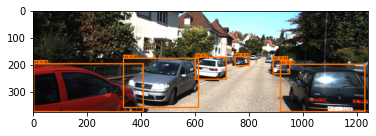

In [14]:
display_yolo_boxes(test_image, out_scores, out_boxes, out_classes,
                   save_file='test_out.png')

# Predicting 2D bounding boxes on KITTI

Now that we have the 2D bounding box (YOLO) model working, we need to predict all of the bounding boxes on KITTI train and test datasets such that the output can be used by the 3D bounding box model. That means we need to output 2 directories of prediction files (for '000001.png', it would be '000001.txt') for training and test images. Each text file needs to be formatted according to the KITTI label file specifications.

In [70]:
def get_label_obj(label_line: str) -> Dict[str, Any]:
    """Returns a dict with all of the label properties.
    :param label_line: A line from a label file.
    :return: A dict representing the label.
    """
    label_arr = label_line.split(' ')
    obj = {}
    obj['type'] = label_arr[0]
    obj['truncation'] = float(label_arr[1])
    obj['occlusion'] = int(label_arr[2])
    obj['alpha'] = float(label_arr[3])
    obj['x1'] = float(label_arr[4])
    obj['y1'] = float(label_arr[5])
    obj['x2'] = float(label_arr[6])
    obj['y2'] = float(label_arr[7])
    obj['height'] = float(label_arr[8])
    obj['width'] = float(label_arr[9])
    obj['length'] = float(label_arr[10])
    obj['tx'] = float(label_arr[11])
    obj['ty'] = float(label_arr[12])
    obj['tz'] = float(label_arr[13])
    obj['ry'] = float(label_arr[14])
    return obj

In [71]:
def get_best_3d_loc(
    label_filename: str,
    box: Tuple[float, float, float, float]) -> Tuple[int, int, int]:
    """Returns the 3D object location for the object whose 2D bounding box has
    the highest IoU with the given 2D box, or the invalid location.
    :param label_filename: The complete path to the label file for the image.
    :param box: The 2D bounding box in (x1, y1, x2, y2) order.
    :return: A 3-tuple of (x, y, z) for the best matching object, or the invalid
    location (-1000, -1000, -1000).
    """
    with open(label_filename, 'r') as infile:
        labels = [line.strip() for line in infile.readlines()]
    best_iou = 0
    best_obj = None
    for line in labels:
        obj = get_label_obj(line)
        obj_box = obj['x1'], obj['y1'], obj['x2'], obj['y2']
        obj_iou = iou(box, obj_box)
        if obj_iou > best_iou or not best_obj:
            best_iou = obj_iou
            best_obj = obj
    if not best_obj:
        return INVALID_3D_LOC, INVALID_3D_LOC, INVALID_3D_LOC
    return best_obj['tx'], best_obj['ty'], best_obj['tz']

In [72]:
def write_yolo_predictions(out_scores: np.ndarray, out_boxes: np.ndarray,
                           out_classes: np.ndarray, height: int, width: int,
                           dst_filename: str,
                           label_filename: Optional[str] = None) -> None:
    """Writes the predicted 2D bounding boxes to the destination file. This is
    based on writeLabels.m in the KITTI devkit.
    :param out_scores: The scores output from the YOLO model prediction.
    :param out_boxes: The boxes output from the YOLO model prediction.
    :param out_classes: The class probabilities output from the YOLO model
    prediction.
    :param height: The image height.
    :param width: The image width.
    :param dst_filename: The filename at which to save the labels.
    :param label_filename: If specified, fill in the 3D location with the data
    from the label file (our model assumes that this data can be obtained from
    lidar sensors).
    """
    output_lines = []
    for i, c in reversed(list(enumerate(out_classes))):
        coco_class = CLASS_NAMES[c]
        if coco_class not in COCO_TO_KITTI_CLASS:
            kitti_class = 'Misc'
        else:
            kitti_class = COCO_TO_KITTI_CLASS[coco_class]
        box = out_boxes[i]
        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(height, np.floor(bottom + 0.5).astype('int32'))
        right = min(width, np.floor(right + 0.5).astype('int32'))
        score = out_scores[i]
        if label_filename is not None:
            loc_3d = get_best_3d_loc(label_filename, (left, top, right, bottom))
        else:
            loc_3d = INVALID_3D_LOC, INVALID_3D_LOC, INVALID_3D_LOC
        label_line = ('{0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11} '
                      '{12} {13} {14} {15}').format(
            kitti_class,
            INVALID_TRUNCATION,
            INVALID_OCCLUSION,
            INVALID_ALPHA,
            left, top, right, bottom,
            INVALID_3D_HWL, INVALID_3D_HWL, INVALID_3D_HWL,
            loc_3d[0], loc_3d[1], loc_3d[2],
            INVALID_RY,
            score)
        output_lines.append(label_line)
    with open(dst_filename, 'w') as outfile:
        outfile.write('\n'.join(output_lines))

In [38]:
def get_image_height_width(image_file: str) -> Tuple[int, int]:
    """Returns the height and width of the image. Because PIL's Image.open() is
    lazy, this does not load the image into memory.
    :param image_file: The image filename.
    :return: A tuple of the image height and width.
    """
    with Image.open(image_file) as image:
        return image.size[::-1]

In [59]:
def predict_on_dir(
    yolo_model: tf.keras.Model,
    sess: tf.Session,
    image_dir: str,
    max_images: Optional[int] = None) -> \
    Dict[str, Tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """Runs the YOLO graph stored in the session on the image.
    :param yolo_model: The YOLO model.
    :param sess: The TensorFlow/Keras session containing the YOLO graph.
    :param image_dir: The path to the image directory on which to predict.
    :param max_images: If specified, the maximum number of images on which to
    predict.
    :return: A dictionary where the keys are the filenames and the values are
    tuple of scores, boxes, classes for the boxes found by YOLO.
    """
    result = {}
    image_files = os.listdir(image_dir)
    if max_images is not None:
        image_files = image_files[:max_images]
    for image_file in tqdm(image_files):
        result[image_file] = predict_on_image(
            yolo_model, sess, os.path.join(image_dir, image_file))
    return result

In [77]:
def write_predictions_on_dir(
    predictions: Dict[str, Tuple[np.ndarray, np.ndarray, np.ndarray]],
    image_dir: str,
    output_dir: str,
    label_dir: Optional[str] = None) -> None:
    """Writes the predicted 2D bounding boxes to the destination directory.
    :param predictions: The predictions on all image files in image_dir.
    :param image_dir: The directory containing the images.
    :param output_dir: The directory to which to save output files.
    :param label_dir: If specified, used to supply 3D object location
    coordinates.
    """
    for image_file in predictions:
        output_file = image_file.replace('.png', '.txt')
        label_file = None if not label_dir else os.path.join(label_dir,
                                                             output_file)
        out_scores, out_boxes, out_classes = predictions[image_file]
        height, width = get_image_height_width(os.path.join(
            image_dir, image_file))
        write_yolo_predictions(out_scores, out_boxes, out_classes,
                               height, width,
                               os.path.join(output_dir, output_file),
                               label_filename=label_file)

In [75]:
height, width = get_image_height_width(test_image)
write_yolo_predictions(out_scores, out_boxes, out_classes, height, width,
                       'test_out.txt',
                       label_filename=os.path.join(TRAIN_LABEL_DIR,
                                                   '000008.txt'))

In [ ]:
kitti_train_predictions = predict_on_dir(yolo_model, sess, TRAIN_IMAGE_DIR,
                                         max_images=100)
write_predictions_on_dir(kitti_train_predictions, TRAIN_IMAGE_DIR,
                         TRAIN_PREDICT_DIR, label_dir=TRAIN_LABEL_DIR)

In [64]:
kitti_test_predictions = predict_on_dir(yolo_model, sess, TEST_IMAGE_DIR,
                                        max_images=100)
write_predictions_on_dir(kitti_test_predictions, TEST_IMAGE_DIR,
                         TEST_PREDICT_DIR)

100%|██████████| 100/100 [45:34<00:00, 27.35s/it]
